In [1]:
%matplotlib inline
variable = 'tasmin'
var_name = variable + "/"
model_name_file = 'NorESM2-MM'
import numpy as np
import time
import xarray as xr
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pickle as pkl
import pickle
import numpy as np
from numpy import *
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sys
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
qmap = importr('qmap')
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
utils = importr("utils")
#extremes = importr("extRemes")
#ismev = importr("ismev")
#eva = importr("eva")
gnFit = importr("gnFit")
from datetime import datetime
statis = importr('stats')
import time
from datetime import datetime
from matplotlib.offsetbox import AnchoredText
from netCDF4 import num2date, date2num
statis = importr('stats')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import glob
import time
from tqdm import tqdm
import sys
sys.setrecursionlimit(10000)
import sys
import time
import traceback
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import sys

In [2]:
if sys.platform =="darwin":

    gcm_path = '/media/udit/cmip6/cmip6_raw_amar_regrided/'
    obs_path = '/Volumes/cmip6/'
    target_folder = '/Volumes/cmip6/'
else:
    gcm_path = '/media/udit/cmip6/cmip6_raw_amar_regrided/'
    obs_path = '/media/udit/cmip6/'
    target_folder = '/media/udit/cmip6/'
    
model_name = model_name_file+'/'

scenarios = ['hist','ssp126','ssp245','ssp370','ssp585']


In [3]:
def bias_correction(x,y):
    q_map = qmap.fitQmap(x, y,method="RQUANT", qstep=0.01, wett_day=False)
    qm1 = qmap.doQmap(y, q_map)
    bias_corrected_output = {}
    bias_corrected_output['params'] = q_map
    bias_corrected_output['outputs'] = qm1
    return bias_corrected_output

def bias_correction_model(y,q_map):
    qm1 = qmap.doQmap(y, q_map)
    bias_corrected_output = {}
    bias_corrected_output['outputs'] = qm1
    return bias_corrected_output



def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx + max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):

    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob.glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

def preproc_hist(ds):
    ds = ds.sel(time = slice('01-01-1951','2014-12-13'),lat = slice(5,38),lon = slice(60,100))
    return ds
def preproc_model(ds):
    ds = ds.sel(lat = slice(5,38),lon = slice(60,100))
    return ds



def preproc_hist2(ds):
    start = pd.to_datetime('1951-01-01', format='%Y%m%d', errors='ignore')
    end = pd.to_datetime('2014-12-13', format='%Y%m%d', errors='ignore')
    ds = ds.sel(time = slice(start,end),lat = slice(5,38),lon = slice(60,100))
    return ds








# here we suppose we only care about the combined mean of each file;
# you might also use indexing operations like .sel to subset datasets



In [4]:
model_path = gcm_path + model_name
model_path_historical = model_path
model_path_RCP126 = model_path 
model_path_RCP245 = model_path
model_path_RCP370 = model_path
model_path_RCP585 = model_path

print(model_path_historical)

/media/udit/cmip6/cmip6_raw_amar_regrided/NorESM2-MM/


In [5]:
prcp_hist = model_path +var_name+ "*historical*.nc"
file_lists = glob.glob(prcp_hist)
print(file_lists)

['/media/udit/cmip6/cmip6_raw_amar_regrided/NorESM2-MM/tasmin/tasmin_day_NorESM2-MM_historical_r1i1p1f1_gn_20150101-21001231.nc']


In [6]:
if variable == "pr":
    observed = (obs_path +"final_kelvin.nc")
    prcp_hist = model_path +var_name+ "*historical*.nc"
    file_lists = glob.glob(prcp_hist)
    try:
        model_hist = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_hist)
    except:
        model_hist = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_hist2)
    
    observed = xr.open_dataset(observed)
    observed = observed['pr']
    observed.isel(time = 1).plot()
    model_hist.pr.values = model_hist.pr.values*86400
    model_hist = model_hist['pr']
    lats = observed.lat.values
    lons = observed.lon.values
    prcp_245 = model_path +var_name+ "*245*.nc"
    prcp_126 = model_path +var_name+ "*126*.nc"
    prcp_585 = model_path +var_name+ "*585*.nc"
    prcp_370 = model_path +var_name+ "*370*.nc"
#     print("reading 45")
    print(prcp_245)
    print(prcp_126)
    file_lists = glob.glob(prcp_245)
    print(file_lists)
    model_245 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)

    file_lists = glob.glob(prcp_126)
    model_126 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    file_lists = glob.glob(prcp_370)
    model_370 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    file_lists = glob.glob(prcp_585)
    model_585 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    
    
    model_245.pr.values = model_245.pr.values*86400
    model_585.pr.values = model_585.pr.values*86400
    model_126.pr.values = model_126.pr.values*86400
    model_370.pr.values = model_370.pr.values*86400
    
    
    model_245 = model_245['pr']
    model_585 = model_585['pr']
    model_126 = model_126['pr']
    model_370 = model_370['pr']
    model_245.close()
    model_585.close()
    model_126.close()
    model_370.close()
    model_hist.close()

In [7]:
if variable == "tasmax" or variable == "tasmin":
    observed = (obs_path +"final_kelvin.nc")
    observed = xr.open_dataset(observed)
    observed.close()
    observed = observed[variable]
    temp_hist = model_path +var_name+ "*historical*.nc"
    print(temp_hist)
    file_lists = glob.glob(temp_hist)
    print(file_lists)
    print("hello")
    try:
        model_hist = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_hist)
    except:
        model_hist = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_hist2)
    
    model_hist[variable].values = model_hist[variable].values
    model_hist = model_hist[variable]
    lats = observed.lat.values
    lons = observed.lon.values
    temp_245 = model_path +var_name+ "*245*.nc"
    temp_126 = model_path +var_name+ "*126*.nc"
    temp_585 = model_path +var_name+ "*585*.nc"
    temp_370 = model_path +var_name+ "*370*.nc"
#     print("reading 45")
    file_lists = glob.glob(temp_245)
    print(file_lists)
    model_245 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)

    file_lists = glob.glob(temp_126)
    model_126 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    file_lists = glob.glob(temp_370)
    model_370 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    file_lists = glob.glob(temp_585)
    model_585 = xr.open_mfdataset( file_lists, concat_dim='time', preprocess=preproc_model)
    
    
    
    model_245[variable].values = model_245[variable].values
    model_585[variable].values = model_585[variable].values
    model_126[variable].values = model_126[variable].values
    model_370[variable].values = model_370[variable].values
    model_245 = model_245[variable]
    model_585 = model_585[variable]
    model_126 = model_126[variable]
    model_370 = model_370[variable]
    model_245.close()
    model_585.close()
    model_126.close()
    model_370.close()

/media/udit/cmip6/cmip6_raw_amar_regrided/NorESM2-MM/tasmin/*historical*.nc
['/media/udit/cmip6/cmip6_raw_amar_regrided/NorESM2-MM/tasmin/tasmin_day_NorESM2-MM_historical_r1i1p1f1_gn_20150101-21001231.nc']
hello


/home/udit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/udit/anaconda3/envs/master/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use th

['/media/udit/cmip6/cmip6_raw_amar_regrided/NorESM2-MM/tasmin/tasmin_day_NorESM2-MM_ssp245_r1i1p1f1_gn_20150101-21001231.nc']


/home/udit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/home/udit/anaconda3/envs/master/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the n

In [8]:
print("reading hist")
model_hist = model_hist.interp(lat = lats, lon = lons)
print("reading 45")

model_245 = model_245.interp(lat = lats, lon = lons)
print("reading 26")

model_126 = model_126.interp(lat = lats, lon = lons)
print("reading 85")

model_585 = model_585.interp(lat = lats, lon = lons)
print("reading 70")
model_370 = model_370.interp(lat = lats, lon = lons)

reading hist
reading 45
reading 26
reading 85
reading 70


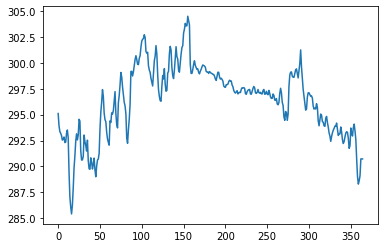

In [9]:
obs_test = observed.isel(lat = 56, lon  = 56)
hist_test = model_hist.isel(lat = 56,lon = 56)
test_245 = model_245.isel(lat = 56,lon = 56)

#test_245 = bias_correction_model(y_245,q_map)
temp = bias_correction(obs_test.values,hist_test.values)
q_map = temp['params']
#test_245_corr = bias_correction_model(test_245.values,q_map)

hist_corr = temp['outputs']

# plt.plot(obs_test[0:365])
# plt.plot(hist_test[0:365])
# plt.plot(hist_corr[0:365])
plt.plot(test_245[0:365])

In [10]:
bias_corrected_results_hist = np.zeros([len(model_hist.time.values),
                                           len(model_hist.lat.values),
                                           len(model_hist.lon.values)])
bias_corrected_results_hist[:] = np.nan


bias_corrected_results_585 = np.zeros([len(model_585.time.values),
                                           len(model_585.lat.values),
                                           len(model_585.lon.values)])
bias_corrected_results_585[:] = np.nan



bias_corrected_results_126 = np.zeros([len(model_126.time.values),
                                           len(model_126.lat.values),
                                           len(model_126.lon.values)])
bias_corrected_results_126[:] = np.nan

bias_corrected_results_245 = np.zeros([len(model_245.time.values),
                                           len(model_245.lat.values),
                                           len(model_245.lon.values)])
bias_corrected_results_245[:] = np.nan

bias_corrected_results_370 = np.zeros([len(model_370.time.values),
                                           len(model_370.lat.values),
                                           len(model_370.lon.values)])
bias_corrected_results_370[:] = np.nan




In [11]:
model_hist_values = model_hist.values
hist_dict = {}
hist_dict['time'] = model_hist.time.values
hist_dict['lon'] =  model_hist.lon.values
hist_dict['lat'] =  model_hist.lat.values

model245_values = model_245.values
rcp245_dict = {}
rcp245_dict['time'] = model_245.time.values
rcp245_dict['lon'] =  model_245.lon.values
rcp245_dict['lat'] =  model_245.lat.values

model585_values = model_585.values

rcp585_dict = {}
rcp585_dict['time'] = model_585.time.values
rcp585_dict['lon'] =  model_585.lon.values
rcp585_dict['lat'] =  model_585.lat.values



model126_values = model_126.values

rcp126_dict = {}
rcp126_dict['time'] = model_126.time.values
rcp126_dict['lon'] =  model_126.lon.values
rcp126_dict['lat'] =  model_126.lat.values

model370_values = model_370.values

rcp370_dict = {}
rcp370_dict['time'] = model_370.time.values
rcp370_dict['lon'] =  model_370.lon.values
rcp370_dict['lat'] =  model_370.lat.values

observation_attr_values = observed.values
print(observation_attr_values.shape)
#observation_attr_values = observation_attr_values.reshape((-1,len(lats),len(lons)))
#print(observation_attr_values.shape)

(124, 147, 24106)


In [12]:
print(model_hist_values.shape)
print(observation_attr_values.shape)
print(model126_values.shape)

(23342, 124, 147)
(124, 147, 24106)
(31390, 124, 147)


In [13]:
correct_params = []
for i,lat in enumerate(lats):
    for j,lon in enumerate(lons):
        params_dict = {}

        if np.isnan(model_hist_values[0,i,j]) or np.isnan(observation_attr_values[i,j,0]):
            bias_corrected_results_hist[:,i,j] = np.nan
            params_dict['lat'] = lat
            params_dict['lon'] = lon
            params_dict['params'] = np.nan
        else:
            try:

                y = model_hist_values[:,i,j]
                x = observation_attr_values[i,j,:]
                
                
                y_245 = model245_values[:,i,j]
                y_585 = model585_values[:,i,j]
                y_126 = model126_values[:,i,j]
                y_370 = model370_values[:,i,j]
                
                temp = bias_correction(x,y)
                q_map = temp['params']
                temp_245 = bias_correction_model(y_245,q_map)
                temp_585 = bias_correction_model(y_585,q_map)
                temp_126 = bias_correction_model(y_126,q_map)
                temp_370 = bias_correction_model(y_370,q_map)
                bias_corrected_results_245[:,i,j] = temp_245['outputs']
                bias_corrected_results_585[:,i,j] = temp_585['outputs']
                bias_corrected_results_126[:,i,j] = temp_126['outputs']
                bias_corrected_results_370[:,i,j] = temp_370['outputs']
                bias_corrected_results_hist[:,i,j] = temp['outputs']

                if i%5==0 and j%5==0:
                    print(lat,lon)
                params_dict['lat'] = lat
                params_dict['lon'] = lon
                params_dict['params'] = temp['params']

            except:
                bias_corrected_results_hist[:,i,j] = np.nan
                bias_corrected_results_245[:,i,j] = np.nan
                bias_corrected_results_126[:,i,j] = np.nan
                bias_corrected_results_585[:,i,j] = np.nan
                bias_corrected_results_370[:,i,j] = np.nan
                params_dict['lat'] = lat
                params_dict['lon'] = lon
                params_dict['params'] = np.nan

        correct_params.append(params_dict)


6.125 81.125
7.375 79.875
7.375 81.125
8.625 77.375
8.625 81.125
9.875 77.375
9.875 78.625
11.125 76.125
11.125 77.375
11.125 78.625
12.375 76.125
12.375 77.375
12.375 78.625
12.375 79.875
13.625 74.875
13.625 76.125
13.625 77.375
13.625 78.625
13.625 79.875
14.875 74.875
14.875 76.125
14.875 77.375
14.875 78.625
14.875 79.875
16.125 73.625
16.125 74.875
16.125 76.125
16.125 77.375
16.125 78.625
16.125 79.875
16.125 81.125
17.375 73.625
17.375 74.875
17.375 76.125
17.375 77.375
17.375 78.625
17.375 79.875
17.375 81.125
17.375 82.375
18.625 73.625
18.625 74.875
18.625 76.125
18.625 77.375
18.625 78.625
18.625 79.875
18.625 81.125
18.625 82.375
18.625 83.625
19.875 73.625
19.875 74.875
19.875 76.125
19.875 77.375
19.875 78.625
19.875 79.875
19.875 81.125
19.875 82.375
19.875 83.625
19.875 84.875
19.875 86.125
21.125 71.125
21.125 73.625
21.125 74.875
21.125 76.125
21.125 77.375
21.125 78.625
21.125 79.875
21.125 81.125
21.125 82.375
21.125 83.625
21.125 84.875
21.125 86.125
22.375 69.875

In [14]:
ds_hist = xr.Dataset({variable: (('time', 'lat','lon'), bias_corrected_results_hist)},
                        coords={'lat': lats,
                                'lon': lons,
                                'time':hist_dict['time'] })


ds_ssp585 = xr.Dataset({variable: (('time', 'lat','lon'), bias_corrected_results_585)},
                        coords={'lat': lats,
                                'lon': lons,
                                'time':rcp585_dict['time'] })

ds_ssp126 = xr.Dataset({variable: (('time', 'lat','lon'), bias_corrected_results_126)},
                        coords={'lat': lats,
                                'lon': lons,
                                'time':rcp126_dict['time'] })

ds_ssp245 = xr.Dataset({variable: (('time', 'lat','lon'), bias_corrected_results_245)},
                        coords={'lat': lats,
                                'lon': lons,
                                'time':rcp245_dict['time'] })

ds_ssp370 = xr.Dataset({variable: (('time', 'lat','lon'), bias_corrected_results_370)},
                        coords={'lat': lats,
                                'lon': lons,
                                'time':rcp370_dict['time'] })

In [15]:
for scenario in scenarios:
    name = "ds_"+ str(scenario)
    ds = globals()[name]
    name_netcdf =  model_name_file + "_" + variable + "_" + str(scenario) + '.nc'
    name_pickle =  model_name_file + "_" + variable + "_" + str(scenario) + '.pkl'
        
    try:
        os.makedirs(target_folder + "/Bias_corrected_kelvin/")
        netcdf_corr = target_folder + "/Bias_corrected_kelvin/"+name_netcdf
        pickle_corr = target_folder + "/Bias_corrected_kelvin/"+name_pickle
        ds.to_netcdf(netcdf_corr)
        if scenario == "hist":
            save_as_pickled_object(correct_params, pickle_corr)


    except FileExistsError:
        netcdf_corr = target_folder + "/Bias_corrected_kelvin/"+name_netcdf
        pickle_corr = target_folder + "/Bias_corrected_kelvin/"+name_pickle
        ds.to_netcdf(netcdf_corr)
        if scenario == "hist":
            save_as_pickled_object(correct_params, pickle_corr)    


In [16]:
%reset -f